In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare data

In [3]:
# Using the cleaned pipeline data
df_pipeline = pd.read_csv('data_cleaned/Pipeline.csv')

print(f"Dataset shape: {df_pipeline.shape}")
print(f"\nFirst few rows:")
print(df_pipeline.head())

Dataset shape: (8800, 8)

First few rows:
  opportunity_id      sales_agent         product  account deal_stage  \
0       1c1i7a6r      moses_frase  gtx_plus_basic  cancity        won   
1       z063oyw0  darcel_schlecht          gtxpro    isdom        won   
2       ec4qe1bx  darcel_schlecht      mg_special  cancity        won   
3       mv1lwrnh      moses_frase       gtx_basic  codehow        won   
4       pe84cx4o        zane_levy       gtx_basic   hatfan        won   

  engage_date  close_date  close_value  
0  2016-10-20  2017-03-01       1054.0  
1  2016-10-25  2017-03-11       4514.0  
2  2016-10-25  2017-03-07         50.0  
3  2016-10-25  2017-03-09        588.0  
4  2016-10-25  2017-03-02        517.0  


Create target variable: 1 for won (converted), 0 for other stages

In [4]:
df_pipeline['converted'] = (df_pipeline['deal_stage'] == 'won').astype(int)

print(f"\nTarget variable distribution:")
print(df_pipeline['converted'].value_counts())
print(f"\nConversion rate: {df_pipeline['converted'].mean():.2%}")



Target variable distribution:
converted
0    4562
1    4238
Name: count, dtype: int64

Conversion rate: 48.16%


## Feature Selection

**Selected Features:**
- `sales_agent`: Which agent handles the opportunity (may indicate skill/experience)
- `product`: What product is being sold (different products have different conversion rates)
- `account`: Which company is the customer (some accounts convert better than others)

In [5]:
feature_columns = ['sales_agent', 'product', 'account']

## Encode Categorical Variables

Converting text categories to numbers so the model can understand them (ML models need numeric input)

In [6]:
label_encoders = {}
df_encoded = df_pipeline.copy()

for col in feature_columns:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

Encoded sales_agent: 30 unique values
Encoded product: 7 unique values
Encoded account: 85 unique values


I included `close_value` as a feature since deal size typically correlates with conversion likelihood (I filled missing values with median)

In [7]:
df_encoded['close_value_filled'] = df_encoded['close_value'].fillna(df_encoded['close_value'].median())

Made final feature set!

In [8]:
feature_cols_encoded = [col + '_encoded' for col in feature_columns] + ['close_value_filled']

## Train-test split

In [9]:
X = df_encoded[feature_cols_encoded]
y = df_encoded['converted']

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

In [10]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set conversion rate: {y_train.mean():.2%}")
print(f"Test set conversion rate: {y_test.mean():.2%}")


Training set size: 7040 samples
Test set size: 1760 samples

Training set conversion rate: 48.15%
Test set conversion rate: 48.18%


## Train GBDT Model

**Parameters:**
- `n_estimators=100`: Build 100 decision trees sequentially
- `learning_rate=0.1`: Each tree contributes 10% to reduce training errors gradually
- `max_depth=3`: Limit tree depth to prevent overfitting
- `min_samples_split=2`: Sllows a split if at least 2 samples are in a node, letting the trees grow as much as possible
- `min_samples_leaf=1`: A leaf can represent just one sample, which can capture fine details in the data
- `subsample=0.8`: Use 80% of data per tree for better generalization
- `random_state=42`: Used a random number
- `verbose=1`: Shows progress messages while the model is training so I can follow along

In [ ]:
# GradientBoostingClassifier(n_estimators = 50, max_depth = 2) # From ML Foundation

gbdt_model = GradientBoostingClassifier(
    n_estimators=100,        # Number of boosting stages
    learning_rate=0.1,       # Shrinks contribution of each tree
    max_depth=3,             # Maximum depth of trees
    min_samples_split=2,     # Minimum samples to split a node
    min_samples_leaf=1,      # Minimum samples in leaf node
    subsample=0.8,           # Fraction of samples for fitting trees
    random_state=42,
    verbose=1
)

In [12]:
gbdt_model.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2266           0.1600            0.31s
         2           1.0923           0.1304            0.30s
         3           0.9816           0.1112            0.26s
         4           0.8847           0.0920            0.26s
         5           0.8043           0.0850            0.26s
         6           0.7318           0.0683            0.26s
         7           0.6716           0.0685            0.25s
         8           0.6164           0.0546            0.26s
         9           0.5469           0.0696            0.25s
        10           0.4836           0.0482            0.24s
        20           0.1639           0.0134            0.21s
        30           0.0595           0.0069            0.18s
        40           0.0265           0.0083            0.15s
        50           0.0118           0.0003            0.14s
        60           0.0084           0.0003            0.12s
       

GradientBoostingClassifier(random_state=42, subsample=0.8, verbose=1)

## Evaluating model

### Making predictions

In [14]:
y_train_pred = gbdt_model.predict(X_train)
y_test_pred = gbdt_model.predict(X_test)

### Calculating accuracy

In [15]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")



Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 0.9994 (99.94%)


**Metrics:**
- precision: accuracy of positive predicitons
- recall: % of actual positives found

In [16]:
print(classification_report(y_test, y_test_pred, target_names=['Not Converted', 'Converted']))

               precision    recall  f1-score   support

Not Converted       1.00      1.00      1.00       912
    Converted       1.00      1.00      1.00       848

     accuracy                           1.00      1760
    macro avg       1.00      1.00      1.00      1760
 weighted avg       1.00      1.00      1.00      1760



### Confusion matrix

**Confusion matrices**: Shows true positives, true negatives, false positives, and false negatives to understand where the model makes mistakes

In [17]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

[[912   0]
 [  1 847]]


## Feature importance

Higher importance = more influential in predictions!

In [18]:
feature_importance = pd.DataFrame({
    'feature': feature_cols_encoded,
    'importance': gbdt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))


Feature Importance Ranking:
            feature  importance
 close_value_filled    0.907391
    product_encoded    0.092439
    account_encoded    0.000124
sales_agent_encoded    0.000046


## Visualizing

### Feature importancee

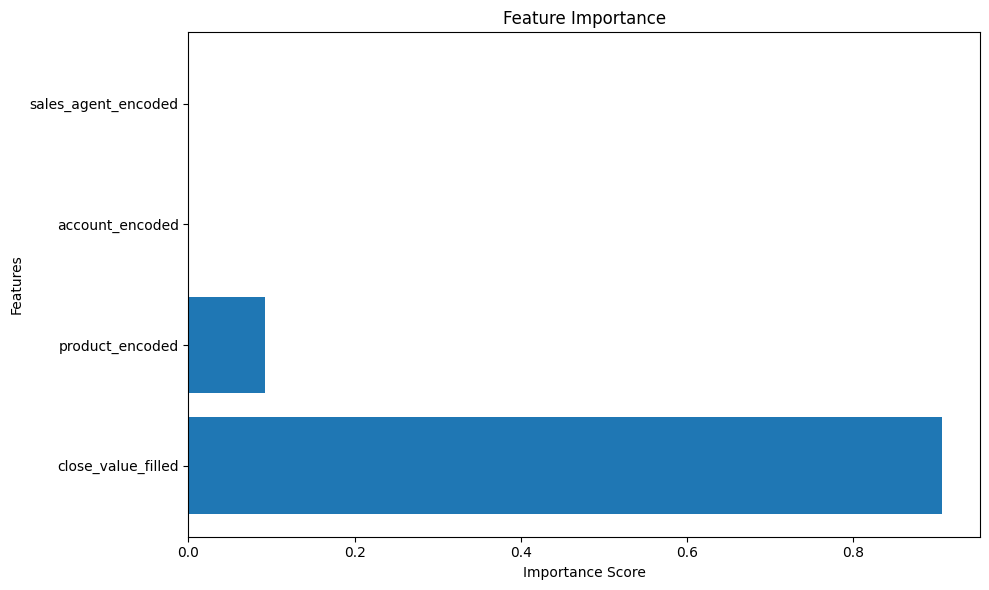

In [19]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Confusion Matrix Heatmap

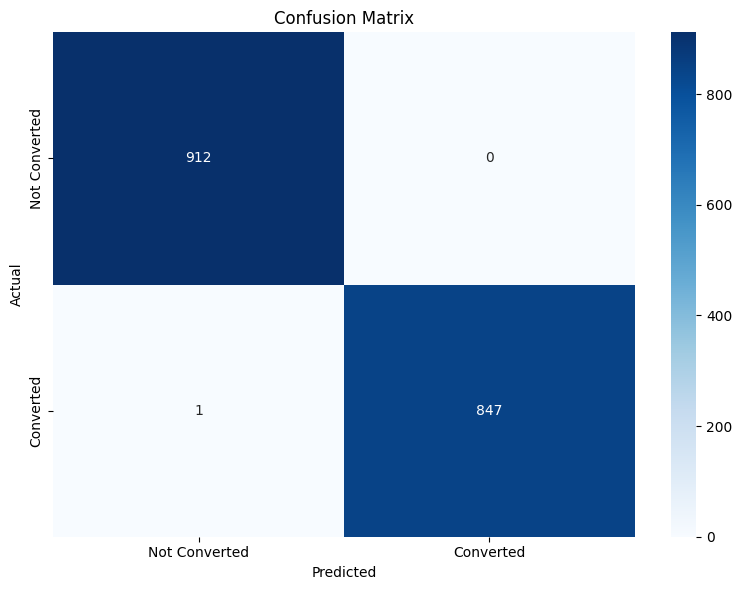

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Converted', 'Converted'],
            yticklabels=['Not Converted', 'Converted'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Model summary stats

In [21]:
print(f"\nModel: GBDT")
print(f"Number of Features: {len(feature_cols_encoded)}")
print(f"Number of Estimators: {gbdt_model.n_estimators}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Model: GBDT
Number of Features: 4
Number of Estimators: 100
Training Samples: 7040
Test Samples: 1760

Final Test Accuracy: 0.9994 (99.94%)
